# Image Segmentation with Trained Model

In [1]:
from model import carotidSegmentation

seg_model = carotidSegmentation()

In [2]:
image_loc = 'data/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_2319.png'

## Plotting Segmentation Images
To plot a segmentation mask for a given ulrasound image, use the model's `.plot_pred()` method, specifying the image's file path location 


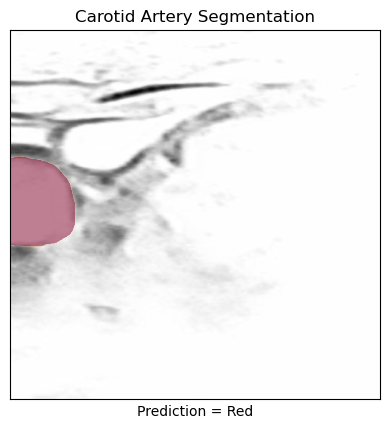

In [3]:
seg_model.plot_pred(image_loc)

#### Plotting Prediction AND Label
The `.plot_pred()` method can plot both predicted segment mask and label mask by setting `labels=True`. This will also calculate the dice loss for the given segmentation prediction relative to the ground truth label.

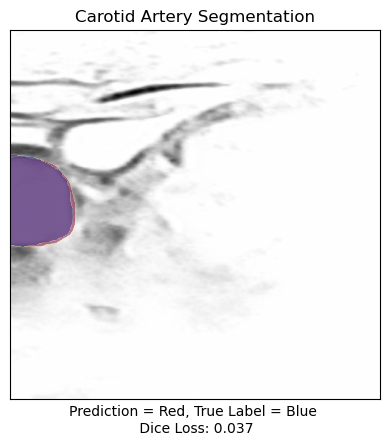

In [4]:
seg_model.plot_pred(image_loc, labels=True)

## Calculate Dice Loss
The dice loss can be calculated for a given image or list of images without plotting via the `.eval()` method:

In [5]:
dice_score = seg_model.eval(image_loc)
print(f'Dice Loss: {dice_score}')

Dice Loss: 0.03703981637954712
